# Configuration

## Dependencies

In [32]:
# import necessary packages
import sys
sys.path.append('..')
import os
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import neuropythy as ny
import matplotlib as mpl
import itertools
import warnings
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from itertools import product
from visualization import plot_contours as viscontours
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Additional matplotlib preferences:
font_data = {'family':'sans-serif',
             'sans-serif':['HelveticaNeue', 'Helvetica', 'Arial'],
             'size': 10,
             'weight': 'light'}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
#mpl.rcParams['figure.dpi'] = 72*2
#mpl.rcParams['savefig.dpi'] = 72*4

## Paths

In [5]:
from pathlib import Path
cache_path       = Path('/data/crcns2021/hcpannot-cache')
image_cache_path = cache_path / 'annot-images'
v123_cache_path  = cache_path / 'annot-v123'
csulc_cache_path = cache_path / 'annot-csulc'
# The save path of the data branch:
data_path = Path('/data/crcns2021/results/data_branch/save')
# The processing path and subpaths:
proc_path    = Path('/data/crcns2021/results/proc')
traces_path  = proc_path / 'traces'
paths_path   = proc_path / 'paths'
means_path   = proc_path / 'means'
labels_path  = proc_path / 'labels'
reports_path = proc_path / 'reports'

# The file of visual surface areas for the ventral data.
ventral_sarea_path = proc_path / 'ventral_sareas.tsv'

# The hcpannot library path; if hcpannot is not on the path for
# this notebook, the notebook will try to figure out where it is
# and will use this directory as a backup.
hcpannot_lib_path = Path('~/code/hcp-annot-vc_analysis')

# If you aren't using /data
os.environ['HCPANNOT_LOAD_PATH'] = os.fspath(cache_path)

In [13]:
# Make sure we can find the hcpannot library. If we were given a path for the
# hcpannot library, we add it to the system path here.
if hcpannot_lib_path:
    hlp = os.path.expandvars(os.fspath(hcpannot_lib_path))
    hlp = os.path.expanduser(hlp)
    if hlp.strip('/').endswith('hcpannot'):
        warnings.warn(
            "adding hcpannot_lib_path that ends with 'hcpannot';"
            " the hcpannot_lib_path should contain the hcpannot directory")
    if os.path.isdir(hlp):
        sys.path.append(hlp)
    else:
        raise ValueError("hcpannot_lib_path is not a directory")
# We try importing it and if we fail, we check to see if we are just running
# the notebook from the work directory and try again.
try:
    import hcpannot
except ModuleNotFoundError:
    hcpannot = None
    if os.getcwd().endswith('/work'):
        hlp = os.path.abspath('..')
        sys.path.append(hlp)
        
# Now we can import the hcp-annot-vc library. (It may have been imported
# above in the try block, but that's fine!)
import hcpannot

# Note the cache path we want to use outside the docker container;
# normally this gets set by the Docker startup, so here outside
# the docker container we set it manually.
hcpannot.interface.default_load_path = str(cache_path)
# We have to update some data after setting this.

# Subject lists. These are defined in the analysis subpackage of
# the hcpannot library, and subject_list_<x> is the <x>th list of
# subject IDs that we assigned.
from hcpannot.config import (
    subject_list,
    subject_list_1,
    subject_list_2,
    subject_list_3)
# The subject IDs we are processing over, as a numpy array.
sids = np.array(subject_list)

# The mean rater's name ('mean') and some plotting functions are also defined in
# the hcpannot.analysis subpackage.
from hcpannot.analysis import plot_contours

# Finally, the proc and meanproc functions, which give us the processed data.
from hcpannot.proc import proc, meanproc

In [14]:
def load_report(region, rater, sid, h):
    """Loads surface area report for the region, rater, sid, and hemisphere.
    
    The region should be the name of one of the contour regions, e.g.
    `'ventral'`. Loads a dictionary of the processing report for the given
    rater, subject, and hemisphere, and returns a processed version of that
    report. The processing includes both square-mm and percentage reports of the
    surface area.
    
    If the file for the report is not found, it is skipped and the values are
    left as NaN.
    """
    from json import load
    data = {
        'rater':rater,
        'sid':sid,
        'hemisphere':h}
    for k in region_areas[region]:
        data[f'{k}_mm2'] = np.nan
        data[f'{k}_percent'] = np.nan
    try:
        path = os.path.join(reports_path, rater, str(sid))
        flnm = os.path.join(path, f'{h}.{region}_sareas.json')
        with open(flnm, 'rt') as fl:
            sarea = load(fl)
        for (k,v) in sarea.items():
            data[f'{k}_mm2'] = v
            if k != 'cortex':
                data[f'{k}_percent'] = v * 100 / sarea['cortex']
    except Exception as e:
        pass
    return data
def load_allreports(region, include_mean=True, sids=subject_list):
    """Loads all reports for a region and returns a dataframe of them.
    
    This runs `load_report` over all raters, subjects, and hemispheres and
    returns a dataframe of all the reports. If a report file is not found,
    then the row is left with NaNs indicating missing data.
    """
    if include_mean:
        if include_mean == True:
            include_mean = 'mean'
        include_mean = [include_mean]
    else:
        include_mean = []
    raters = (region_raters[region] + include_mean)
    return pd.DataFrame(
        [load_report(region, rater, sid, h)
         for rater in raters
         for sid in sids
         for h in ('lh', 'rh')])
def nestget(d, k):
    """Retrieves nested data from the proc dictionaries.
    
    Certain keys such as `'boundaries'` are accessible in the dictionaries that
    are returned by the `proc` function only via the `'nested_data'` key, which
    typically contains another proc dictionary with additional data. The
    `nestget` function gets data from these embedded dictionaries.
    """
    while k not in d:
        d = d['nested_data']
    return d[k]

## Annot-metadata
 * contours, trace: the raw lines (VO1_VO2) saved in .json file that we drew
 * path: processed contours

In [15]:
# The sets of raters we use.
ventral_raters = [
    'BrendaQiu',
    'bogengsong',
    'JiyeongHa',
    'lindazelinzhao',
    'nourahboujaber',
    'jennifertepan']
region_raters = {
    'ventral': ventral_raters}

# The visual areas included in each pipeline/region.
region_areas = {
    'early': ('V1', 'V2', 'V3'),
    'ventral': ('hV4', 'VO1', 'VO2'),
    'dorsal': ('V3a', 'V3b', 'IPS0', 'LO1')}

roi_list = []
#roi_list += [k for k in region_areas['early']]
roi_list += [k for k in region_areas['ventral']]

# The hemispheres we are processing over.
hemis = ['lh', 'rh']

contour_list = ['hV4', 'hV4_VO1', 'VO1_VO2', 'VO_outer']


# Get raw contour .json files

In [16]:
contours_df = pd.DataFrame({})
for hemi, contour, researcher in itertools.product(hemis, contour_list, ventral_raters):
    tmp_df = pd.DataFrame({})
    trace_path_list = viscontours.get_contour_list_drawn_by_rater(data_path,
                                                                  hemi,
                                                                  contour,
                                                                  researcher,
                                                                  return_full_path=True)
    tmp_df['sid'] = [int(k.split('/')[-2]) for k in trace_path_list]
    tmp_df['researcher'] = researcher
    tmp_df['contour'] = contour
    tmp_df['hemi'] = hemi
    contours_df = pd.concat((contours_df, tmp_df))

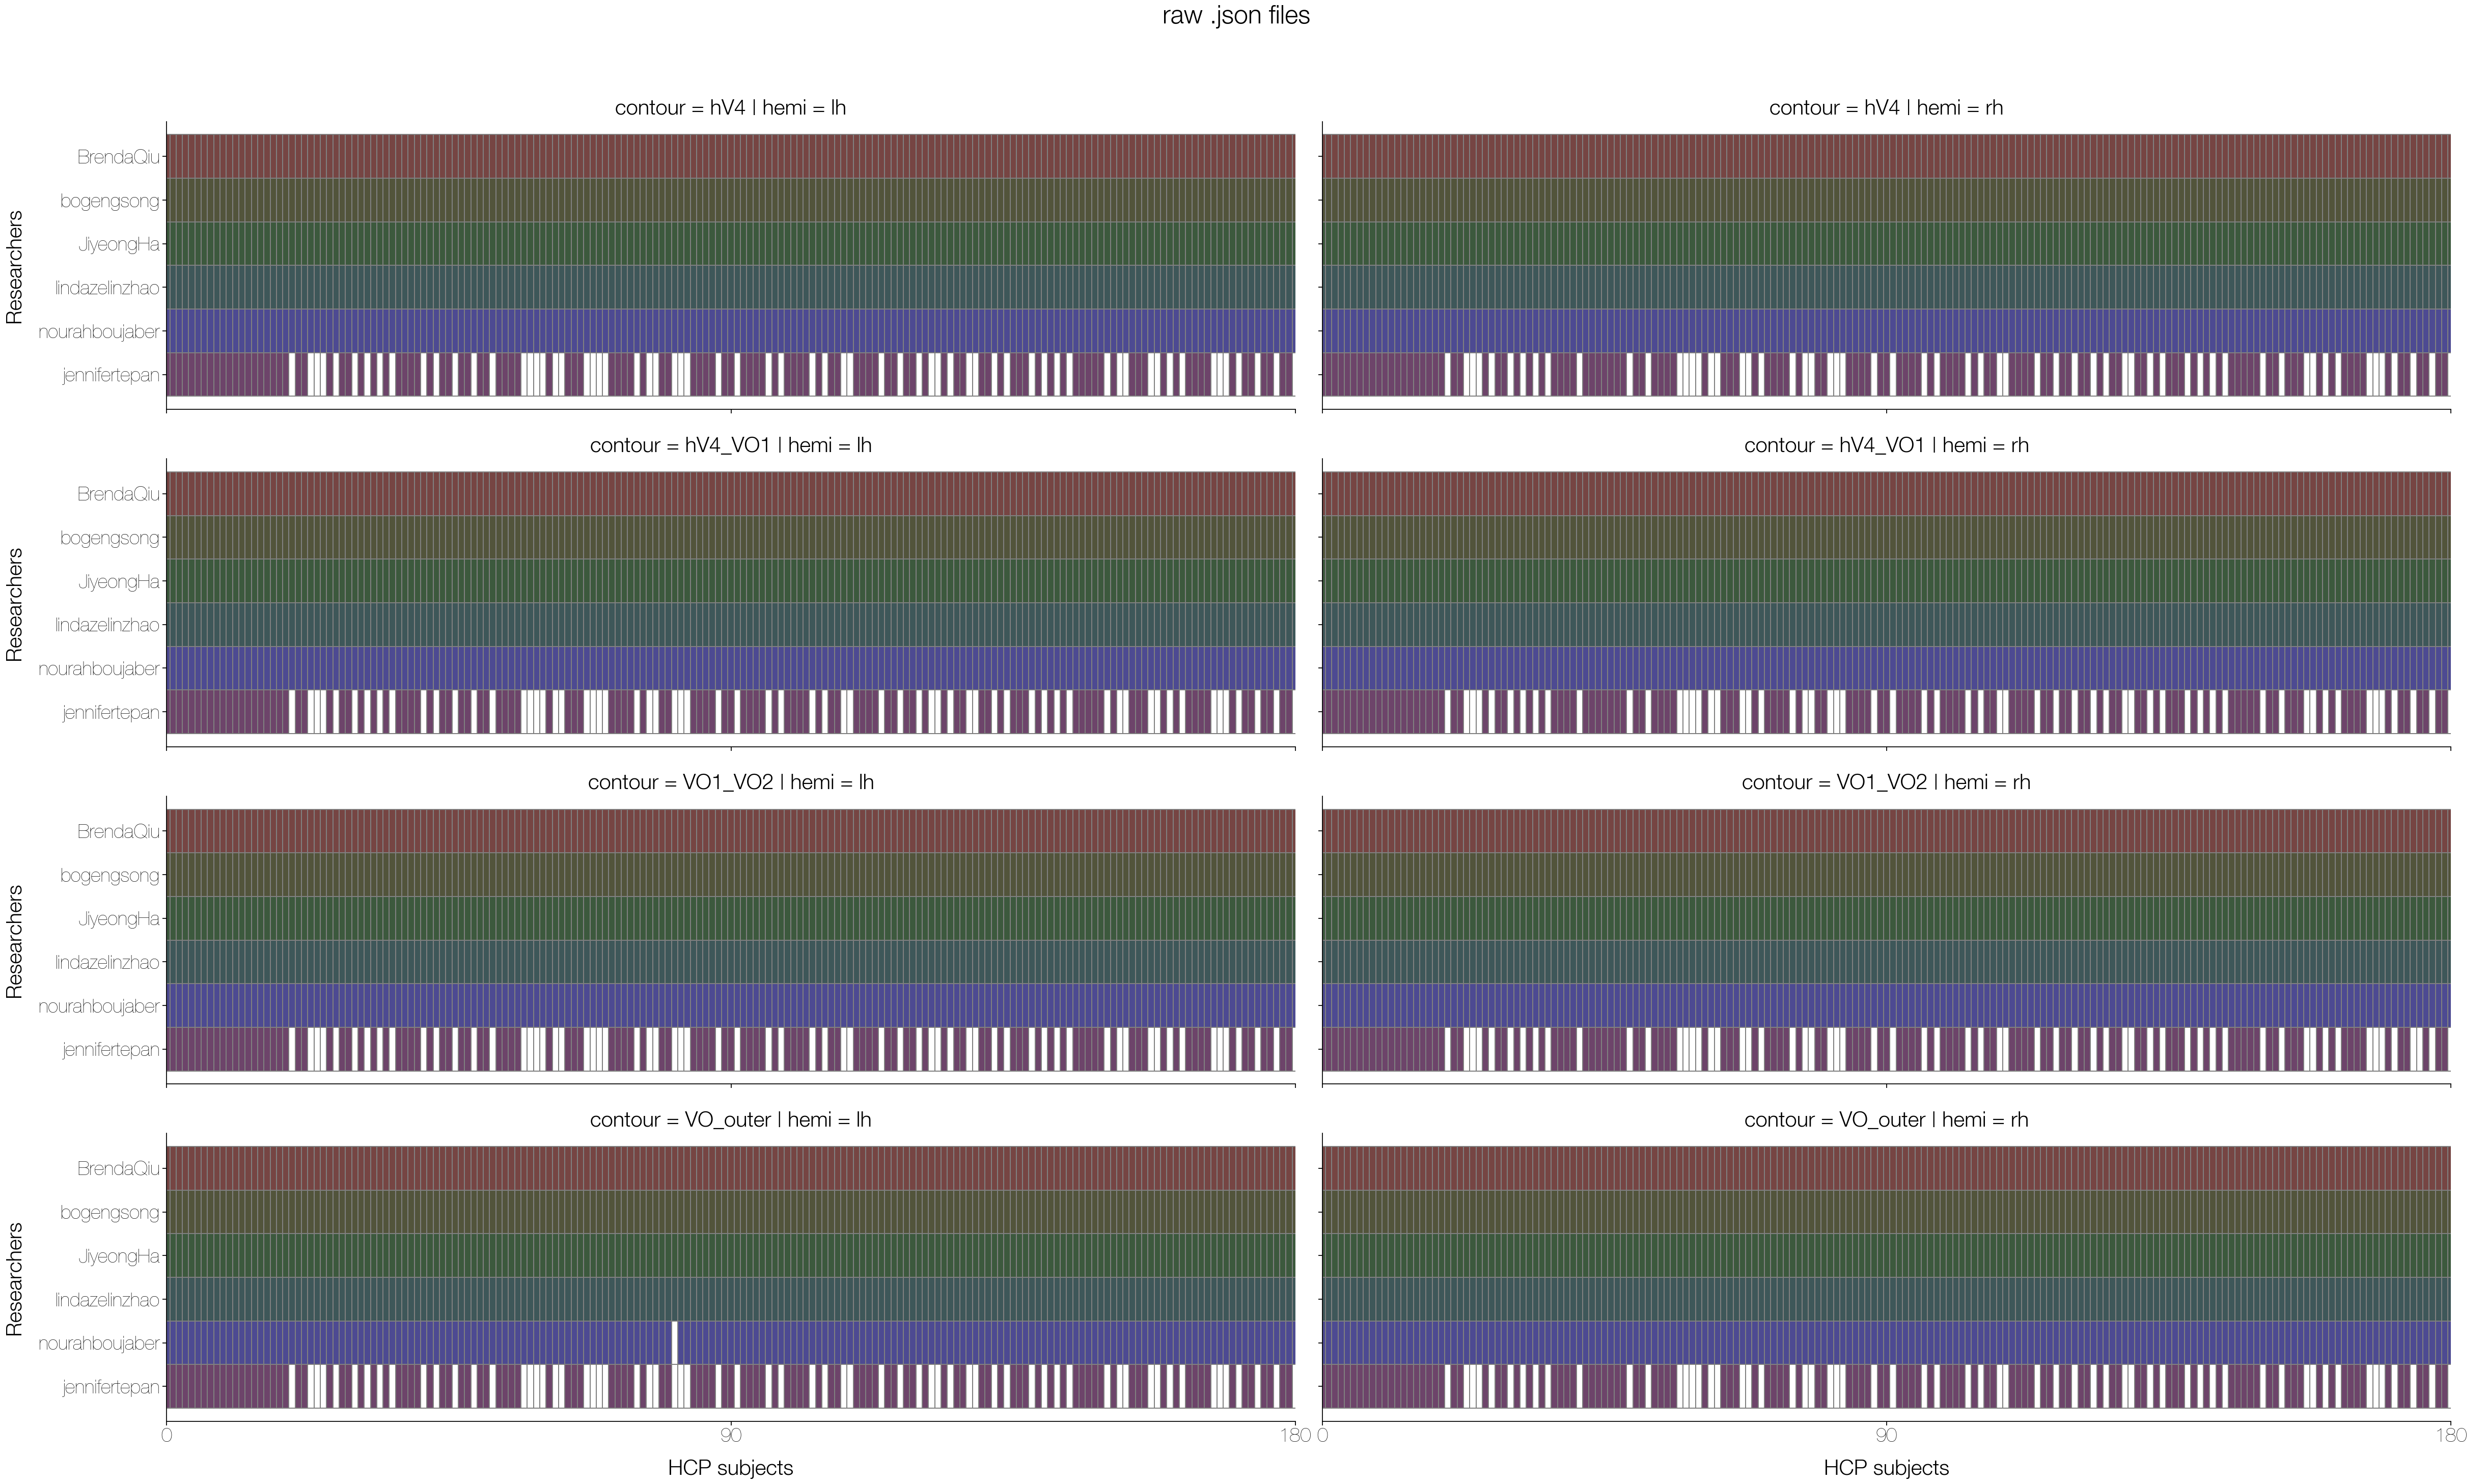

In [17]:
viscontours.check_sids(df=contours_df,
                       sid='sid', y='researcher',
                       col='hemi', col_order=hemis,
                       row='contour', row_order=contour_list,
                       height=7, suptitle='raw .json files',
                       hue='researcher', hue_order=ventral_raters, save_path=None)

# Make Path

```python
rater     = 'mean'
hemi      = 'lh'
contour   = contour_list[0]
sid       = '169444'
n_points  = 500
stream    = 'ventral'
save_path = os.path.join(proc_path, 'fsaverage', 
                       f"cacherater_{rater}_{sid}_{hemi}_{contour}.mgz")
viscontours.make_fsaverage_coords('ventral',
                                  rater,
                                  hemi,
                                  contour,
                                  sid,
                                  n_points,
                                  data_dir,
                                  proc_path,
                                  save_path,
                                  verbose=True,
                                  return_annot=True)
```

# Get contour files

Now I'm going to read in traced files. These traced files are processed based on each of the raw .json files that we (researchers) submitted to have equal number of coordinate points. These will act like cache files, so that Brenda and I don't have to run code for creating these trace files every time we analyze the data.

In [102]:
contour_list_df = pd.DataFrame({})
for rater, hemi, roi in itertools.product(ventral_raters+['mean'], hemis, roi_list):
    tmp = pd.DataFrame({})
    path_list = glob(os.path.join(proc_path, 'fsaverage', f'cacherater_{rater}_??????_{hemi}_{roi}.mgz'))
    sub_list = [k.split(f'cacherater_{rater}_')[-1][:6] for k in path_list]
    sub_list = [int(k) for k in sub_list]
    tmp['sid'] = sub_list 
    tmp['researcher'] = rater 
    tmp['roi'] = roi
    tmp['hemi'] = hemi
    assert len(sub_list) == len(path_list)
    if len(path_list) != 181:
        print(rater, hemi, roi, len(path_list))
    contour_list_df = pd.concat((contour_list_df, tmp))

bogengsong lh VO2 180
lindazelinzhao lh VO2 174
lindazelinzhao rh VO2 180
nourahboujaber lh hV4 179
nourahboujaber lh VO1 178
nourahboujaber lh VO2 178
jennifertepan lh hV4 115
jennifertepan lh VO1 115
jennifertepan lh VO2 115
jennifertepan rh hV4 119
jennifertepan rh VO1 119
jennifertepan rh VO2 119


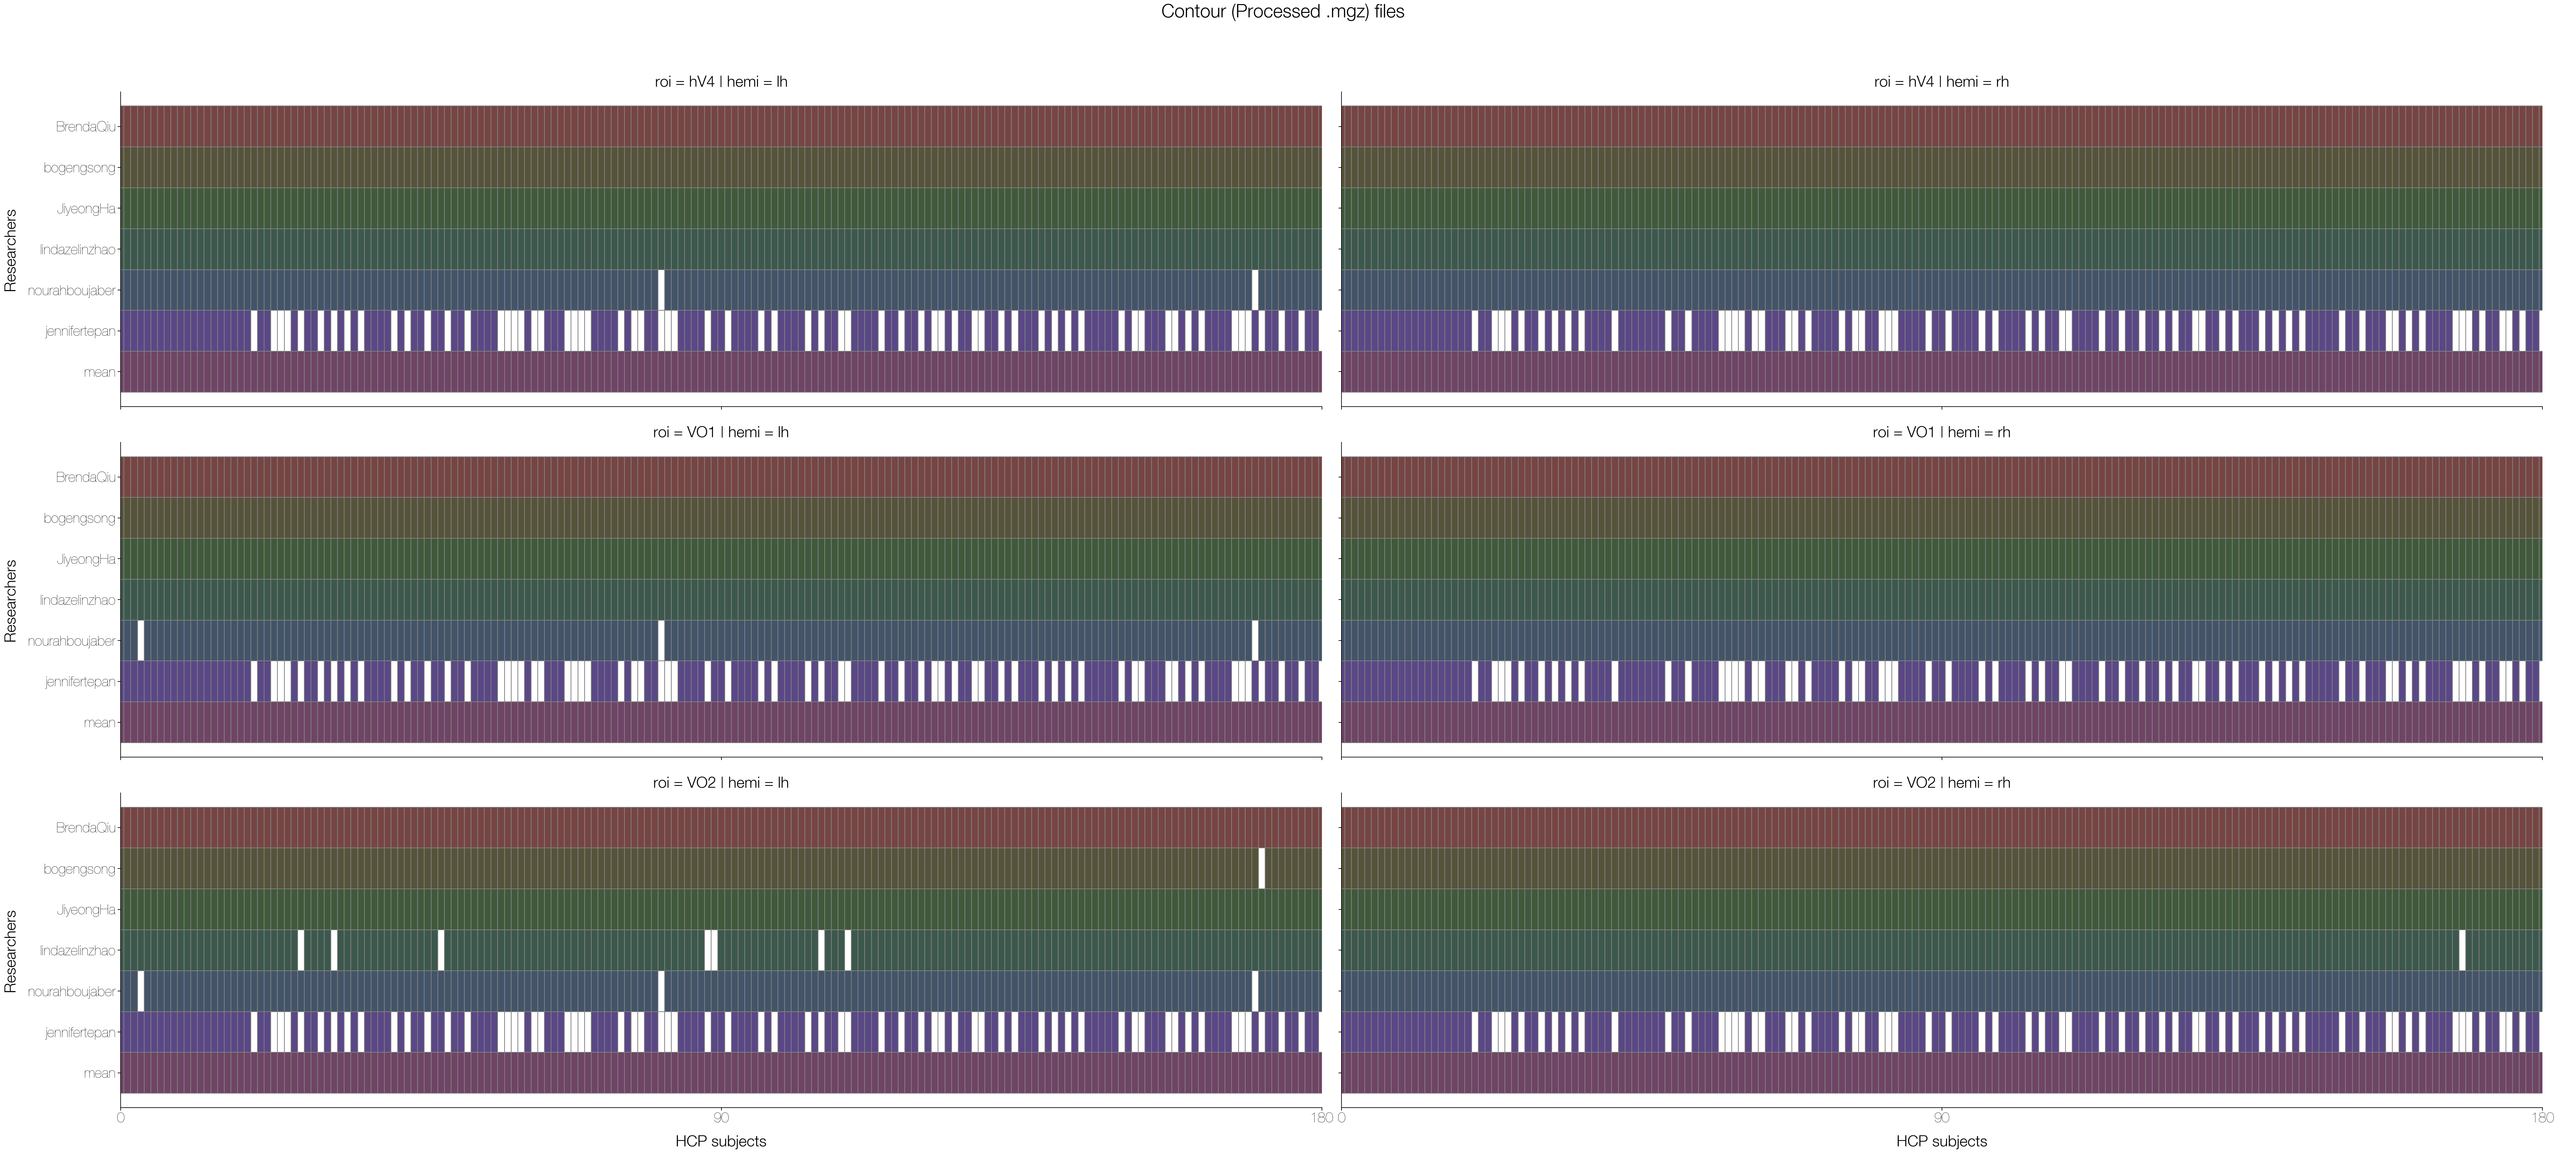

In [104]:
viscontours.check_sids(df=contour_list_df,
                       sid='sid', y='researcher',
                       col='hemi', col_order=hemis,
                       row='roi', row_order=roi_list,
                       height=10, suptitle='Contour (Processed .mgz) files',
                       hue='researcher', hue_order=ventral_raters+['mean'], save_path=None)

# Plot individual ROIs 

In [ ]:
roi_colors = plt.get_cmap('Set1', 10)(np.asarray([0.0, 0.1, 0.2, 0.3, 0.4, 0.5]))
roi_colors = {'hV4': roi_colors[0],
              'VO1': roi_colors[2],
              'VO2': roi_colors[1]}

Below is a code snippet copied from Brenda's github. We'll see if this works fine in this notebook to check the files we're using are the same as those used in her github notebook.

In [29]:


def create_LineCollection(sids, hemi, roi, 
                          path=data_path, 
                          color=None):
    
    sid_plotted = []
    lines = [] 
    for sid in sids:
        mean_cache_file = os.path.join(proc_path, 'fsaverage', f"cacherater_mean_{sid}_{hemi}_{roi}.mgz")
        if os.path.isfile(mean_cache_file):
            sid_plotted.append(sid)
            mean_coord = ny.load(mean_cache_file)
            mean_coord = np.column_stack(mean_coord)
            lines.append(mean_coord)
    lc = LineCollection(lines, linewidths=0.2, alpha = 0.2, colors = color)
    sid_missing = [s for s in sids if s not in sid_plotted]
    return (sid_missing, lc)

def plot_averages(sids, hemi, roi,
                      path=data_path,
                      ax=None,
                      colors=None):  
    
    if ax == None:
        (fig, ax) = plt.subplots(1,1, figsize=(5,3), dpi=72*8)

    if isinstance(roi, list):
        for k in roi:
            (sid_missing, lc) = create_LineCollection(sids, hemi, k, path, color=roi_colors.get(k, 'gray'))
            ax.add_collection(lc)
            num_missing = len(sid_missing)
            print(f'{hemi}, {k}, {num_missing} subjects not plotted', sid_missing)
        ax.set_title(' '.join(roi))
    else:
        (sid_missing, lc) = create_LineCollection(sids, hemi, roi, path, color=roi_colors.get(roi, 'gray'))
        ax.add_collection(lc)
        num_missing = len(sid_missing)
        #print(f'{hemi}, {k}, {num_missing} subjects not plotted')
        ax.set_title(roi)
   
    ax.set_xlim(-60, 60)
    ax.set_ylim(-100, 20)
    

lh, hV4, 0 subjects not plotted []
lh, VO1, 0 subjects not plotted []
lh, VO2, 0 subjects not plotted []
rh, hV4, 0 subjects not plotted []
rh, VO1, 0 subjects not plotted []
rh, VO2, 0 subjects not plotted []


/home/jiyeongha/.conda/envs/vwm/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/home/jiyeongha/.conda/envs/vwm/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


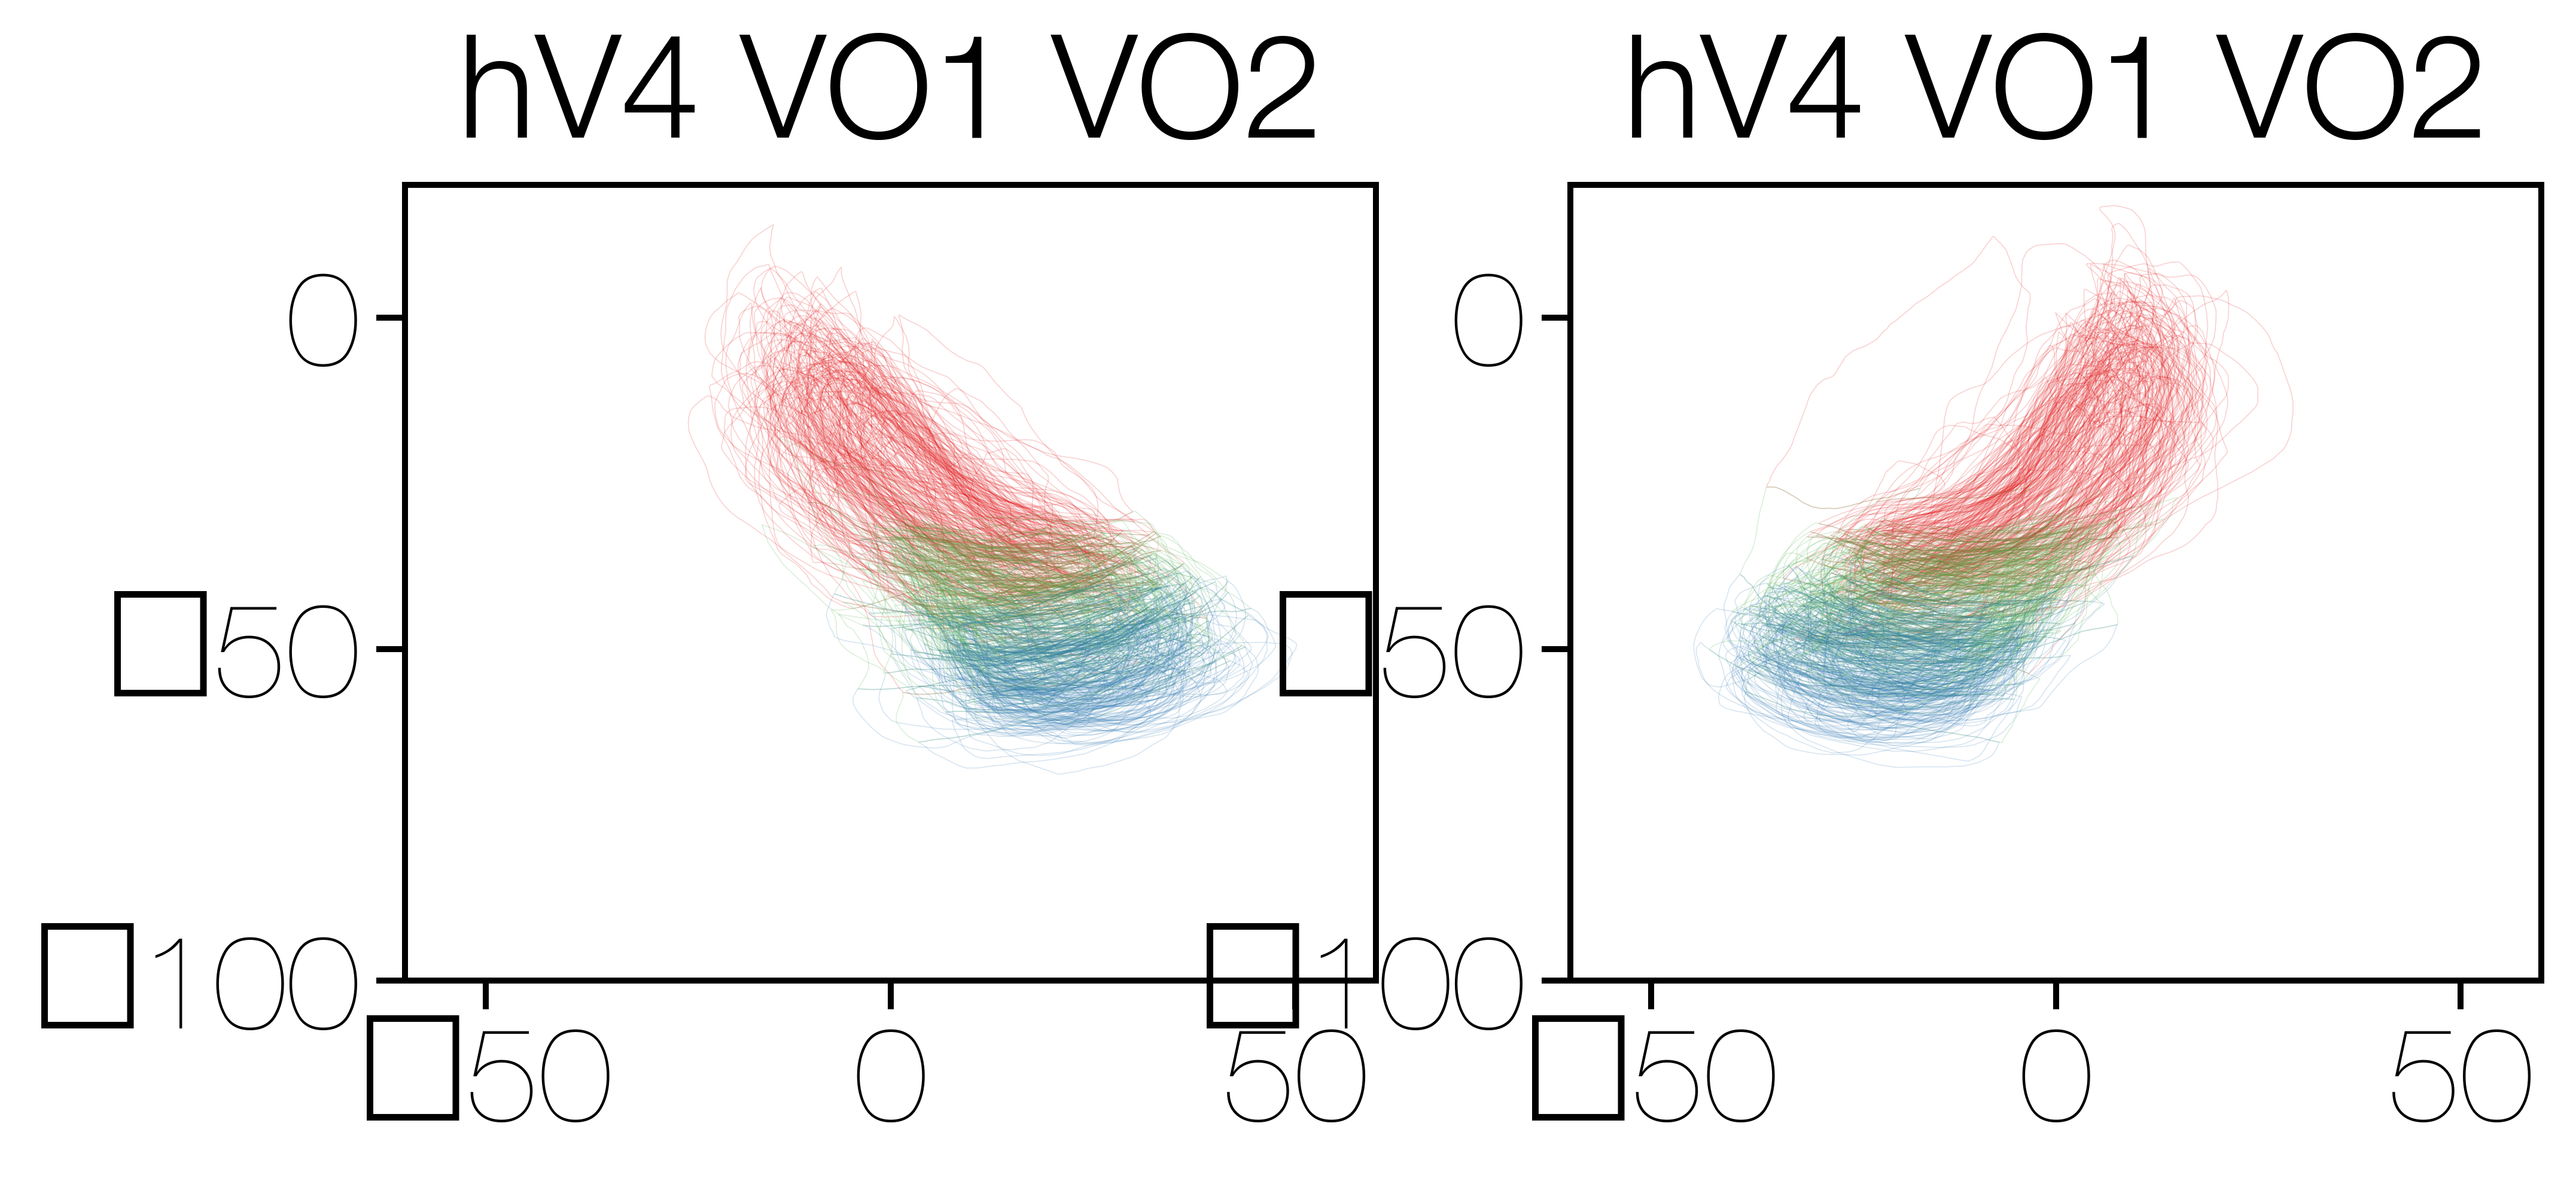

In [30]:
(fig,axes) = plt.subplots (1,2, figsize=(8,3), dpi=72*8)
plot_averages(sids, 'lh', ['hV4','VO1','VO2'], ax=axes[0], colors=roi_colors)
plot_averages(sids, 'rh', ['hV4','VO1','VO2'], ax=axes[1], colors=roi_colors)

# Calculate mean contours across subjects

In [60]:
rater      = 'JiyeongHa'
hemi       = 'lh'
contour    = contour_list[0]
sid        = '169444'
n_points   = 500
stream     = 'ventral'

subj_ids  = contour_list_df.query('researcher == @rater')
subj_ids  = subj_ids.query('contour == @contour')
subj_ids  = subj_ids.query('hemi == @hemi')
subj_ids  = subj_ids['sid'].to_list()

In [108]:
def get_subj_ids_for_rater(subj_ids_df, rater, hemi, roi):
    subj_ids  = subj_ids_df.query('researcher == @rater')
    subj_ids  = subj_ids.query('roi == @roi')
    subj_ids  = subj_ids.query('hemi == @hemi')
    return subj_ids['sid'].to_list()

In [86]:
rater      = 'lindazelinzhao'
k = f'{rater}_{hemi}_{roi}'
contour_coords[k] = []
for sid in subj_ids[:10]:
    cache_file = os.path.join('fsaverage', f"cacherater_{rater}_{sid}_{hemi}_{roi}.mgz")
    tmp = viscontours.make_fsaverage_contours('ventral',
                                         rater=rater,
                                         sid=sid,
                                         hemisphere=hemi,
                                         roi=roi,
                                         n_points=500,
                                         data_dir=data_path,
                                         proc_dir=proc_path,
                                         cache_file=cache_file,
                                         verbose=False)
    contour_coords[k].append(tmp)
contour_coords[k] = np.asarray(contour_coords[k])

AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [109]:
contour_coords = {}
for rater, hemi, roi in product(ventral_raters, hemis, roi_list):
    k = f'{rater}_{hemi}_{roi}'
    contour_coords[k] = []
    subj_ids = get_subj_ids_for_rater(contour_list_df, rater, hemi, roi)
    for sid in subj_ids[:10]:
        cache_file = os.path.join('fsaverage', f"cacherater_{rater}_{sid}_{hemi}_{roi}.mgz")
        tmp = viscontours.make_fsaverage_contours('ventral',
                                             rater=rater,
                                             sid=sid,
                                             hemisphere=hemi,
                                             roi=roi,
                                             n_points=500,
                                             data_dir=data_path,
                                             proc_dir=proc_path,
                                             cache_file=cache_file,
                                             verbose=False)
        contour_coords[k].append(tmp)
    contour_coords[k] = np.asarray(contour_coords[k])


In [110]:
contour_coords[k]

array([[[-38.905163, -39.04917 , -39.19343 , ..., -38.758442,
         -38.831673, -38.905163],
        [-40.81314 , -40.926228, -41.038418, ..., -40.97815 ,
         -40.896095, -40.81314 ]],

       [[-32.034294, -32.110386, -32.218224, ..., -31.765179,
         -31.899736, -32.034294],
        [-43.493176, -43.599403, -43.70532 , ..., -43.39548 ,
         -43.44433 , -43.493176]],

       [[-38.209072, -38.25579 , -38.30086 , ..., -37.972157,
         -38.088535, -38.209072],
        [-47.36127 , -47.558277, -47.75718 , ..., -47.448612,
         -47.402496, -47.36127 ]],

       ...,

       [[-33.9155  , -34.020546, -34.126938, ..., -33.73097 ,
         -33.821102, -33.9155  ],
        [-38.48111 , -38.58086 , -38.67974 , ..., -38.516296,
         -38.500076, -38.48111 ]],

       [[-39.447727, -39.5811  , -39.714478, ..., -39.329536,
         -39.3919  , -39.447727],
        [-48.445396, -48.43018 , -48.414963, ..., -48.594986,
         -48.52369 , -48.445396]],

       [[-37.6236

In [106]:

# get path of mean cache file
def get_contours(rater, subject_ids, hemi, roi, proc_path, contour_path):
    coordinates = {}
    
    cache_file = os.path.join(proc_path, 'fsaverage', f"cacherater-{rater}_sid-mean_hemi-{hemi}_roi-{roi}.mgz")
    # check if they have an existing cache file, if so load the coordinates of the contour directly
    if os.path.isfile(cache_file):
        coordinates[rater] = ny.load(cache_file)

    # otherwise, find the contour through vc_plan
    else: 
        try:
            dat = meanproc('ventral', 
                           rater=rater, 
                           sid=subject_id, 
                           hemisphere=hemi, 
                           save_path=proc_path, 
                           load_path=contour_save_path) 
            trace = dat['traces'][roi]
            # coordinates are defined by deault as 500 evenly spaced points along the trace curve 
            coordinates[rater] = trace.curve.linspace(npoints)
            cortex = dat['cortex']
            fmap1 = dat['flatmap']
            fmap2 = ny.to_flatmap('occipital_pole', cortex)
            addr = fmap1.address(coordinates[rater])
            coordinates[rater] = fmap2.unaddress(addr)
            ny.save(cache_file, coordinates[rater])

        except Exception as e:
            print(e)
            
    return coordinates

In [ ]:
get_contours('JiyeongHa', subject_ids, 'lh', roi, proc_path, contour_path)

In [ ]:
def plot_contours(raters, subject_id, hemi, roi,
                  plot_average=True,
                  plot_individuals=True,
                  plot_figure=True,
                  plot_colors=rater_plot_colors,
                  axes=None,
                  lw=None,
                  npoints = 500):
    
    load_ind = plot_individuals
    coordinates = {}

    # get path of mean cache file
    if plot_average:
        
        cache_file = os.path.join(proc_path, 'fsaverage', f"cache_rater_{rater}_mean_{hemi}_{roi}.mgz")
            
        # check if they have an existing cache file, if so load the coordinates of the contour directly
        if os.path.isfile(cache_file):
            coordinates[r] = ny.load(cache_file)

        # otherwise, find the contour through vc_plan
        else: 
            try:
                dat = proc('ventral', 
                               rater=rater, 
                               sid=subject_id, 
                               hemisphere=hemi, 
                               save_path=proc_path, 
                               load_path=contour_save_path)
                trace = dat['traces'][roi]
                # coordinates are defined by deault as 500 evenly spaced points along the trace curve 
                coordinates[r] = trace.curve.linspace(npoints)

                cortex = dat['cortex']
                fmap1 = dat['flatmap']
                fmap2 = ny.to_flatmap('occipital_pole', cortex)
                addr = fmap1.address(coordinates[r])
                coordinates[r] = fmap2.unaddress(addr)

                ny.save(cache_file, coordinates[r])
            
            except Exception as e:
                print(e)
   
    # Make the plots:   
    if plot_figure == True:
        
        # If axes is not specified, get the current axes.
        if axes is None:
            axes = plt.gca()

        for (k, (x,y)) in coordinates.items():
            c = plot_colors.get(k, 'gray')
            axes.plot(x, y, '-', color=c, lw=lw, label=k) 
            
        # plot the legends
        axes.legend()
    
    # print message
    print (subject_id, hemi, 'finished')

# Plot averaged ROIs 

In [83]:
def lwplot(x, y, axes=None, fill=True, edgecolor=None, color=None, **kw):
    '''
    lwplot(x, y) is equivalent to pyplot.plot(x, y), however the linewidth or lw options
      are interpreted in terms of the coordinate system instead of printer points.
    lwplot(x, y, ax) plots on the given axes ax.

    All optional arguments that can be passed to pyplot's Polygon can be passed to lwplot.
    '''
    from neuropythy.util import zinv
    import pimms
    import matplotlib as mpl

    lw = kw['linewidth'] if 'linewidth' in kw else kw['lw'] if 'lw' in kw else None
    if 'linewidth' in kw:
        lw = kw.pop('linewidth')
    elif 'lw' in kw:
        lw = kw.pop('lw')
    else:
        lw = 0
    axes = plt.gca() if axes is None else axes
    if len(x) < 2: raise ValueError('lwplot line must be at least 2 points long')
    # we plot a particular thickness; we need to know the orthogonals at each point...
    pts = np.transpose([x, y])
    dd = np.vstack([[pts[1] - pts[0]], pts[2:] - pts[:-2], [pts[-1] - pts[-2]]])
    nrm = np.sqrt(np.sum(dd ** 2, 1))
    dd *= np.reshape(zinv(nrm), (-1, 1))
    dd = np.transpose([dd[:, 1], -dd[:, 0]])
    # we make a polygon or a trimesh...
    if pimms.is_vector(lw): lw = np.reshape(lw, (-1, 1))
    xy = np.vstack([pts + lw * dd, np.flipud(pts - lw * dd)])
    n = len(pts)
    if pimms.is_vector(color) and len(color) == n:
        clr = np.concatenate([color, np.flip(color)])
        (nf0, nf1) = (np.arange(n - 1), np.arange(1, n))
        (nb0, nb1) = (2 * n - nf0 - 1, 2 * n - nf1 - 1)
        tris = np.hstack([(nf0, nf1, nb0), (nb0, nb1, nf1)]).T
        (x, y) = xy.T
        tri = mpl.tri.Triangulation(x, y, tris)
        if 'cmap' not in kw: kw['cmap'] = 'hot'
        return axes.tripcolor(tri, clr, shading='gouraud',
                              linewidt=0, **kw)
    else:
        mean_contours = axes.plot(x, y, 'k-', linewidth=0)

        pg = plt.Polygon(xy, closed=True, fill=fill, edgecolor=edgecolor,
                         linestyle=None, linewidth=0, color=color, **kw)

        return axes.add_patch(pg)
        
def find_interquartile_range(my_list, axis=0):
    """ takes in a 2d list which consists of subjects on the row and each dot point as a column.
    The default purpose is to find the IQR around each point index (across sid)"""
    return np.percentile(my_list, 75, axis=axis) - np.percentile(my_list, 25, axis=axis)

def calculate_IQR_summary(x, y, axis=0):
    x_iqr = find_interquartile_range(x, axis=axis)
    y_iqr = find_interquartile_range(y, axis=axis)
    return np.sqrt(x_iqr ** 2 + y_iqr ** 2)


In [96]:
roi_mean_x, roi_mean_y, roi_iqr_xy = {},{},{}

for hemi, roi in product(['lh','rh'], roi_list):
    path_list = glob(os.path.join(proc_path, 'fsaverage', f"cacherater_mean_??????_{hemi}_{roi}.mgz"))
    sids_list = [int(k.split('mean_')[1][:6]) for k in path_list]
    x_list, y_list = [], []
    for f in path_list:
        x, y = ny.load(f)
        x_list.append(x)
        y_list.append(y)
    dict_key = f'{hemi}-{roi}'
    roi_mean_x[dict_key] = np.mean(x_list, axis=0)
    roi_mean_y[dict_key] = np.mean(y_list, axis=0)
    roi_iqr_xy[dict_key] = calculate_IQR_summary(x_list, y_list, axis=0)


/tmp/ipykernel_4958/3928081413.py:19: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout(w_pad=3)


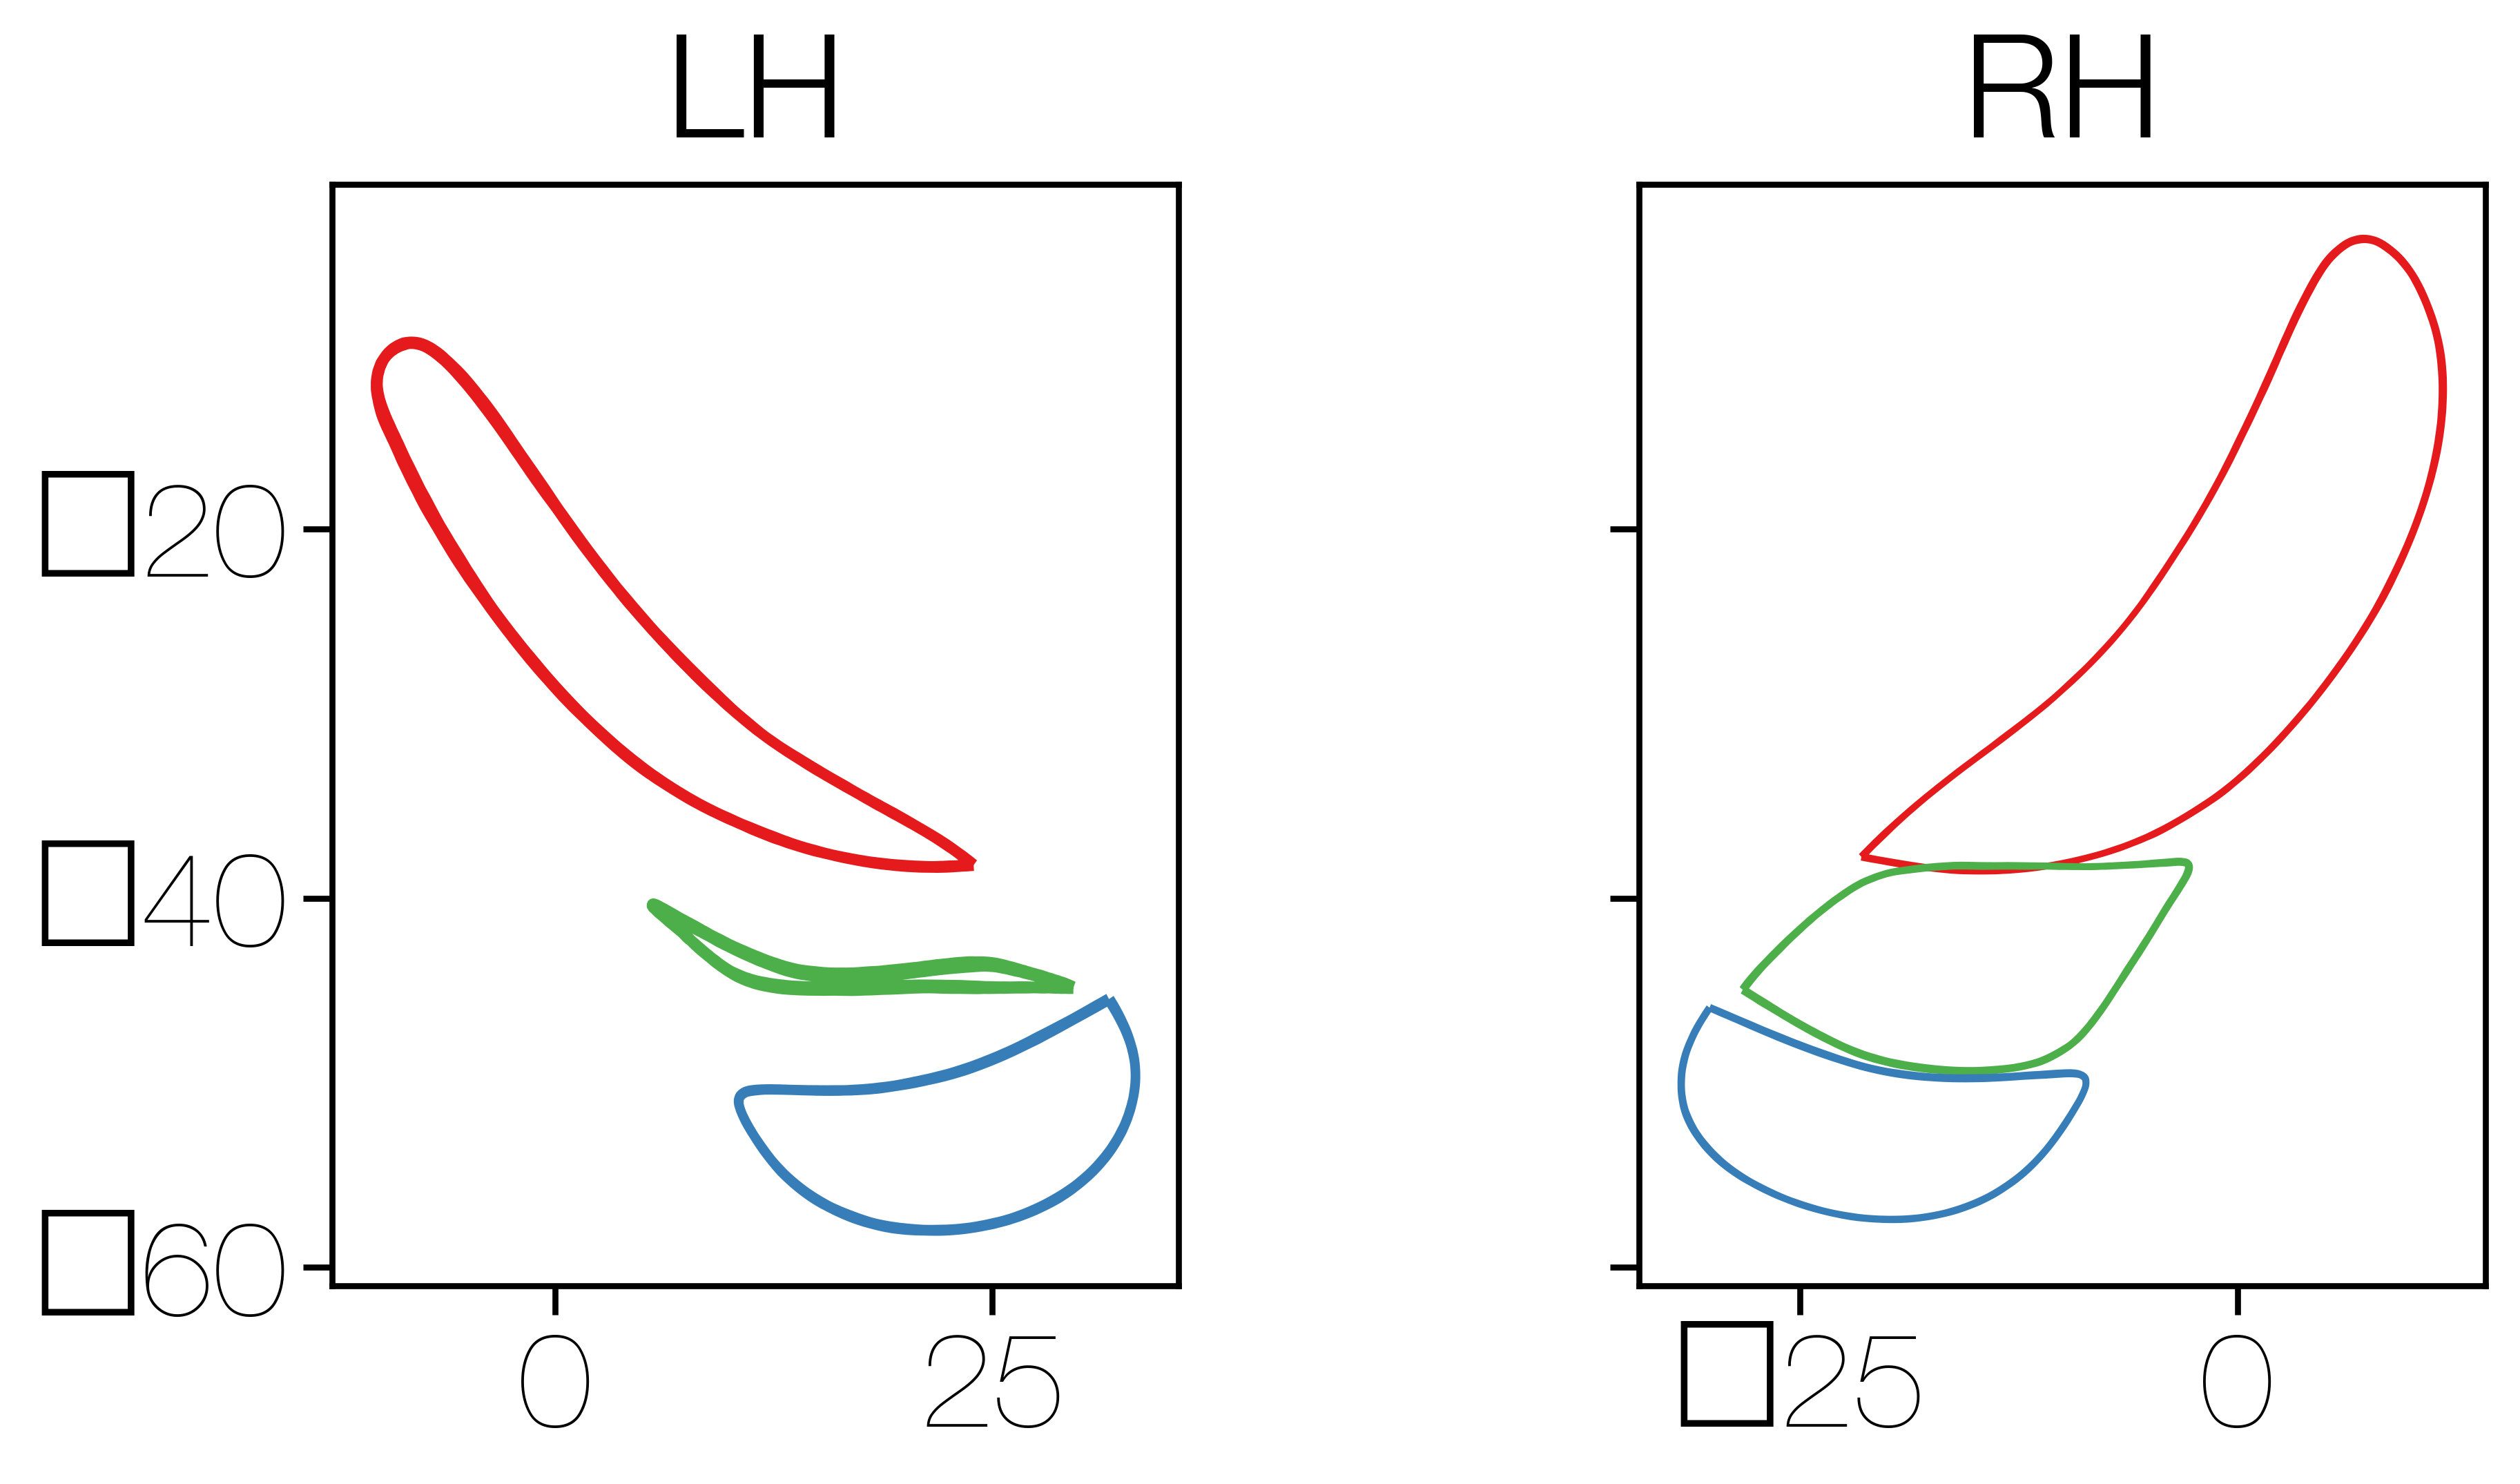

In [104]:
fig, axes = plt.subplots(1, 2,
                         sharey=True,
                         dpi=500, figsize=(8, 5))

for roi in roi_list:
    dict_key = f'lh-{roi}'
    lwplot(roi_mean_x[dict_key], roi_mean_y[dict_key],
                       axes=axes[0], color=roi_colors.get(roi, 'gray'),
                       lw=roi_iqr_xy[dict_key] * 0.03)

    
    dict_key = f'rh-{roi}'                             
    lwplot(roi_mean_x[dict_key], roi_mean_y[dict_key],
                       axes=axes[1], color=roi_colors.get(roi, 'gray'),
                       lw=roi_iqr_xy[dict_key] * 0.02)
    
axes[0].set_title('LH')
axes[1].set_title('RH')
plt.tight_layout(w_pad=3)
#plt.tight_layout(w_pad=2, h_pad=2)
#plt.savefig('/Volumes/server/Projects/annot-vc/derivatives/figures/rater-avg_roi-all.svg',
#            bbox_inches='tight', transparent=True)